In [1]:
import pandas as pd
import numpy as np
import datetime
from EvGym import config

save = False

In [2]:
df_elaad = df_elaad = pd.read_csv("data/elaadnl_open_ev_datasets.csv", parse_dates = ["UTCTransactionStart", "UTCTransactionStop"])
df_elaad = df_elaad.rename(columns = config.elaad_rename)

In [3]:
df_elaad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session               10000 non-null  int64         
 1   ChargePoint           10000 non-null  object        
 2   Connector             10000 non-null  int64         
 3   starttime_parking     10000 non-null  datetime64[ns]
 4   endtime_parking       10000 non-null  datetime64[ns]
 5   StartCard             10000 non-null  object        
 6   connected_time_float  10000 non-null  float64       
 7   charged_time_float    10000 non-null  float64       
 8   total_energy          10000 non-null  float64       
 9   max_power             10000 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 781.4+ KB


In [4]:
df_elaad.head()

,session,ChargePoint,Connector,starttime_parking,endtime_parking,StartCard,connected_time_float,charged_time_float,total_energy,max_power
0,3491779,0abf481c2d3f5866a8fc7feaae460fd0,1,2019-08-27 14:52:00,2019-08-27 17:58:00,0c24de2f8216313f75daf876ec7c2223e17c866462ae41...,3.11,3.10,9.86,3.342
1,3326963,a22a6a745ff09431c3a0cef7373042ee,2,2019-03-01 10:14:00,2019-03-01 13:13:00,fd31273615db1421e4be23b51db9f1c5c904ebed131b5d...,3.00,3.00,9.38,3.440
2,3469263,f4f5e5fbf8297d4889e49f10942b030b,1,2019-07-31 12:54:00,2019-07-31 13:21:00,f876668fd30216c9054a890007143b4d40d13ddd9234c7...,0.46,0.46,1.45,3.160
3,3429356,0f87094588f6330a84f30797f0458fc8,1,2019-06-16 10:55:00,2019-06-16 14:35:00,06776db669a8f444bf7f81edc7fcf6c18c51bfd90eed2f...,3.65,3.65,38.77,10.813
4,3332751,77f3b31920754dac44d2b7400f16bca3,1,2019-03-07 21:21:00,2019-03-08 07:22:00,f88e7e074d5476d4e8a532ae1e1966de2d3f333f3c4453...,10.03,7.15,26.14,3.884


In [5]:
df_elaad["start_hour"] = df_elaad["starttime_parking"].dt.hour
df_elaad["day_no"] = (pd.to_datetime(df_elaad["starttime_parking"].dt.date) - datetime.datetime(year = 2019, month = 1, day = 1)).dt.days

# Clean vehicles that have higher charged_time than connected time
df_elaad["charged_time_float"] = np.minimum(df_elaad["charged_time_float"], df_elaad["connected_time_float"])

df_elaad["energy_supplied"] = np.minimum(config.alpha_c * config.eta_c * df_elaad["charged_time_float"], config.B * config.FINAL_SOC)
df_elaad["soc_arr"] = (config.FINAL_SOC - df_elaad["energy_supplied"]/ (config.B))


df_elaad["charged_time"] = np.ceil(df_elaad["charged_time_float"]) 
df_elaad["connected_time"] = np.ceil(df_elaad["connected_time_float"])

df_elaad["ts_arr"] = np.floor((df_elaad["starttime_parking"] - config.starttime_min).dt.total_seconds() / config.timestep)

if config.timestep == 3600:
    # This way it is consistent with connected_time
    df_elaad["ts_dep"] = df_elaad["ts_arr"] + df_elaad["connected_time"]
else:
    df_elaad["ts_dep"] = np.ceil((df_elaad["endtime_parking"] - config.starttime_min).dt.total_seconds() / config.timestep)
df_elaad["ts_soj"] = df_elaad["ts_dep"] - df_elaad["ts_arr"]
df_elaad["laxity"] = df_elaad["connected_time"] - (config.FINAL_SOC - df_elaad["soc_arr"]) * config.B / (config.alpha_c*config.eta_c)
df_elaad["depart_hour"] = df_elaad["start_hour"] + df_elaad["connected_time"] # Look how 
df_elaad["xi"] = df_elaad["laxity"] * config.psi * config.alpha_c
df_elaad["laxity_float"] = df_elaad["connected_time_float"] - (config.FINAL_SOC - df_elaad["soc_arr"]) * config.B / (config.alpha_c*config.eta_c)

df_elaad = df_elaad.sort_values(by = ["ts_arr", "ts_dep"]).reset_index(drop = True)

In [6]:
# Excecutive decision: there is one session that starts in 2019 and ends in 2020. We drop that one
df_elaad = df_elaad[df_elaad["ts_dep"] < 175320].reset_index(drop = True)

In [7]:
df_elaad.describe()

,session,Connector,starttime_parking,endtime_parking,connected_time_float,charged_time_float,total_energy,max_power,start_hour,day_no,...,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
count,9.997000e+03,9997.000000,9997,9997,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,...,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9.997000e+03,9997.000000,9.997000e+03,9.997000e+03
mean,3.452763e+06,1.360308,2019-07-11 11:10:26.353906176,2019-07-11 16:59:39.029708800,5.820084,2.877626,13.634439,5.589205,12.411323,190.927678,...,0.612447,3.354906,6.325598,171154.675603,171161.001200,6.325598,3.672141e+00,18.736921,1.978880e+01,3.166627e+00
min,3.261657e+06,1.000000,2019-01-01 00:30:00,2019-01-01 08:24:00,0.020000,0.020000,0.100000,0.167000,0.000000,0.000000,...,0.000000,1.000000,1.000000,166560.000000,166568.000000,1.000000,-4.440892e-16,2.000000,-2.393152e-15,-8.881784e-16
25%,3.360960e+06,1.000000,2019-04-04 12:28:00,2019-04-04 16:18:00,1.510000,1.250000,4.530000,3.398000,9.000000,93.000000,...,0.498375,2.000000,2.000000,168804.000000,168808.000000,2.000000,5.300000e-01,13.000000,2.856117e+00,0.000000e+00
50%,3.452128e+06,1.000000,2019-07-10 07:15:00,2019-07-10 13:11:00,3.380000,2.240000,7.830000,3.640000,12.000000,190.000000,...,0.668160,3.000000,4.000000,171127.000000,171133.000000,4.000000,9.600000e-01,16.000000,5.173344e+00,3.100000e-01
75%,3.547565e+06,2.000000,2019-10-22 05:59:00,2019-10-22 12:34:00,8.390000,3.500000,18.260000,7.277000,16.000000,294.000000,...,0.801562,4.000000,9.000000,173621.000000,173629.000000,9.000000,4.801484e+00,21.000000,2.587472e+01,4.410000e+00
max,3.634022e+06,2.000000,2019-12-31 17:46:00,2019-12-31 21:04:00,161.170000,25.670000,93.929000,22.500000,23.000000,364.000000,...,0.967305,26.000000,162.000000,175313.000000,175317.000000,162.000000,1.548015e+02,175.000000,8.342098e+02,1.539715e+02
std,1.075844e+05,0.480114,NaN,NaN,7.094334,2.644101,14.283505,3.333594,4.531763,110.507278,...,0.257299,2.649885,7.091561,2652.263849,2652.549167,7.091561,6.333161e+00,9.163897,3.412877e+01,6.333746e+00


In [8]:
if save:
    df_elaad.to_csv("data/df_elaad_preproc.csv", index = False)

## EDA

Can be skipped

In [9]:
df_elaad[["connected_time", "ts_soj"]].describe()

,connected_time,ts_soj
count,9997.000000,9997.000000
mean,6.325598,6.325598
std,7.091561,7.091561
min,1.000000,1.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,9.000000,9.000000
max,162.000000,162.000000


In [10]:
df_elaad[["depart_hour"]].describe()

,depart_hour
count,9997.000000
mean,18.736921
std,9.163897
min,2.000000
25%,13.000000
50%,16.000000
75%,21.000000
max,175.000000


In [11]:
df_elaad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session               9997 non-null   int64         
 1   ChargePoint           9997 non-null   object        
 2   Connector             9997 non-null   int64         
 3   starttime_parking     9997 non-null   datetime64[ns]
 4   endtime_parking       9997 non-null   datetime64[ns]
 5   StartCard             9997 non-null   object        
 6   connected_time_float  9997 non-null   float64       
 7   charged_time_float    9997 non-null   float64       
 8   total_energy          9997 non-null   float64       
 9   max_power             9997 non-null   float64       
 10  start_hour            9997 non-null   int32         
 11  day_no                9997 non-null   int64         
 12  energy_supplied       9997 non-null   float64       
 13  soc_arr           

In [12]:
df_elaad.describe()

,session,Connector,starttime_parking,endtime_parking,connected_time_float,charged_time_float,total_energy,max_power,start_hour,day_no,...,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
count,9.997000e+03,9997.000000,9997,9997,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,...,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9.997000e+03,9997.000000,9.997000e+03,9.997000e+03
mean,3.452763e+06,1.360308,2019-07-11 11:10:26.353906176,2019-07-11 16:59:39.029708800,5.820084,2.877626,13.634439,5.589205,12.411323,190.927678,...,0.612447,3.354906,6.325598,171154.675603,171161.001200,6.325598,3.672141e+00,18.736921,1.978880e+01,3.166627e+00
min,3.261657e+06,1.000000,2019-01-01 00:30:00,2019-01-01 08:24:00,0.020000,0.020000,0.100000,0.167000,0.000000,0.000000,...,0.000000,1.000000,1.000000,166560.000000,166568.000000,1.000000,-4.440892e-16,2.000000,-2.393152e-15,-8.881784e-16
25%,3.360960e+06,1.000000,2019-04-04 12:28:00,2019-04-04 16:18:00,1.510000,1.250000,4.530000,3.398000,9.000000,93.000000,...,0.498375,2.000000,2.000000,168804.000000,168808.000000,2.000000,5.300000e-01,13.000000,2.856117e+00,0.000000e+00
50%,3.452128e+06,1.000000,2019-07-10 07:15:00,2019-07-10 13:11:00,3.380000,2.240000,7.830000,3.640000,12.000000,190.000000,...,0.668160,3.000000,4.000000,171127.000000,171133.000000,4.000000,9.600000e-01,16.000000,5.173344e+00,3.100000e-01
75%,3.547565e+06,2.000000,2019-10-22 05:59:00,2019-10-22 12:34:00,8.390000,3.500000,18.260000,7.277000,16.000000,294.000000,...,0.801562,4.000000,9.000000,173621.000000,173629.000000,9.000000,4.801484e+00,21.000000,2.587472e+01,4.410000e+00
max,3.634022e+06,2.000000,2019-12-31 17:46:00,2019-12-31 21:04:00,161.170000,25.670000,93.929000,22.500000,23.000000,364.000000,...,0.967305,26.000000,162.000000,175313.000000,175317.000000,162.000000,1.548015e+02,175.000000,8.342098e+02,1.539715e+02
std,1.075844e+05,0.480114,NaN,NaN,7.094334,2.644101,14.283505,3.333594,4.531763,110.507278,...,0.257299,2.649885,7.091561,2652.263849,2652.549167,7.091561,6.333161e+00,9.163897,3.412877e+01,6.333746e+00


In [13]:
df_elaad[["laxity", "laxity_float"]].describe()

,laxity,laxity_float
count,9.997000e+03,9.997000e+03
mean,3.672141e+00,3.166627e+00
std,6.333161e+00,6.333746e+00
min,-4.440892e-16,-8.881784e-16
25%,5.300000e-01,0.000000e+00
50%,9.600000e-01,3.100000e-01
75%,4.801484e+00,4.410000e+00
max,1.548015e+02,1.539715e+02


In [14]:
df_elaad["session"].nunique()

9997

In [15]:
ts_max = df_elaad["ts_dep"].max()
ts_min = df_elaad["ts_arr"].min()
delta_ts = ts_max -ts_min
delta_ts / 24

364.875

In [16]:
print(df_elaad["starttime_parking"].min())
print(df_elaad["endtime_parking"].max())

2019-01-01 00:30:00
2019-12-31 21:04:00


In [17]:
df_elaad.head()

,session,ChargePoint,Connector,starttime_parking,endtime_parking,StartCard,connected_time_float,charged_time_float,total_energy,max_power,...,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
0,3261657,e62c50d1be0a2f80ec51d471f9630a4e,2,2019-01-01 00:30:00,2019-01-01 08:24:00,826d337c1d84900452edfcb27a3fb11bcbd06f35da8406...,7.91,1.00,6.53,9.818,...,0.835250,1.0,8.0,166560.0,166568.0,8.0,7.00,8.0,37.722302,6.910000e+00
1,3262038,9bae10789a789973cc7f05d2a96df76f,1,2019-01-01 10:36:00,2019-01-01 12:52:00,26612ba143072faddaa884c2b04208992c5f44d97e5a24...,2.27,2.27,8.08,3.600,...,0.664118,3.0,3.0,166570.0,166573.0,3.0,0.73,13.0,3.933897,0.000000e+00
2,3262129,5ab468315a1f42feb6d0a87307593352,1,2019-01-01 11:49:00,2019-01-01 17:50:00,8478920deafe847713d1707d8f71a043c59fa066e55020...,6.02,3.75,11.56,3.400,...,0.464688,4.0,7.0,166571.0,166578.0,7.0,3.25,18.0,17.513926,2.270000e+00
3,3262170,00fa448dfcba79a12a3cea56fb48d63f,2,2019-01-01 12:22:00,2019-01-01 14:29:00,e8e1953d3e6221f971ce3299d2fa8275cdc9e7700e2b39...,2.12,0.87,3.84,7.973,...,0.852768,1.0,3.0,166572.0,166575.0,3.0,2.13,15.0,11.478357,1.250000e+00
4,3262208,e35645c6b4adb10224ecfbdff6bc5473,1,2019-01-01 12:51:00,2019-01-01 15:16:00,6490d53fbbe95d74592928292858f9b156d838f08d062e...,2.41,2.41,8.50,3.592,...,0.645253,3.0,3.0,166572.0,166575.0,3.0,0.59,15.0,3.179451,4.440892e-16


In [18]:
import matplotlib.pyplot as plt

(0.0, 1000.0)

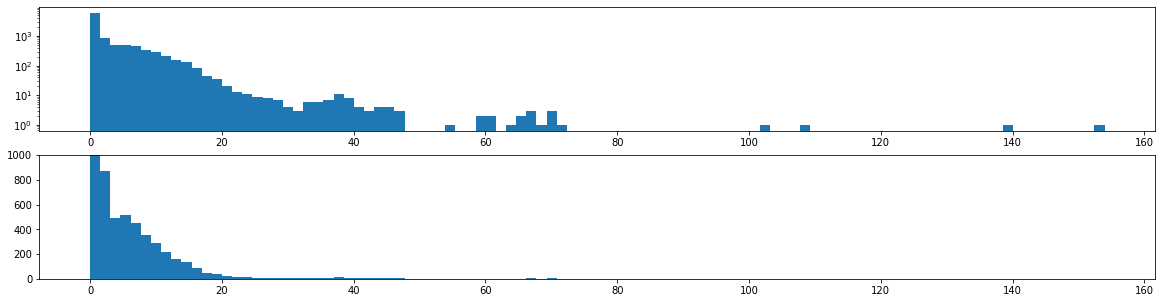

In [19]:
lax_f = df_elaad["laxity_float"] 
fig1 = plt.figure(figsize = (20, 5))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.set_yscale('log')
ax1.hist(lax_f, bins = 100);

ax2.hist(lax_f, bins = 100);
ax2.set_ylim(0, 1000)




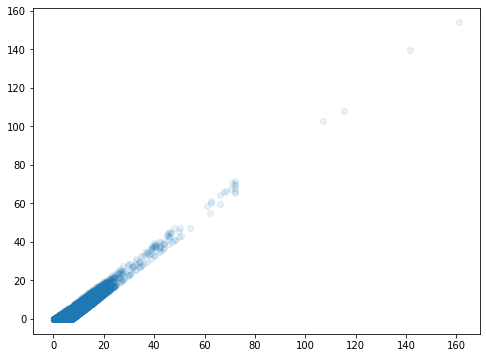

In [20]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.scatter(df_elaad["connected_time_float"], df_elaad["laxity_float"], alpha=0.1)

array([[<Axes: title={'center': 'total_energy'}>]], dtype=object)

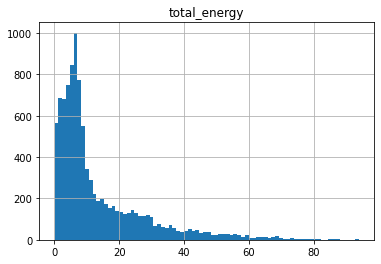

In [21]:
df_elaad[["total_energy"]].hist(bins = 80)

In [22]:
df_elaad["soc_arr2"] = np.minimum(np.maximum(config.FINAL_SOC - df_elaad["total_energy"] / config.B, 0), config.FINAL_SOC)


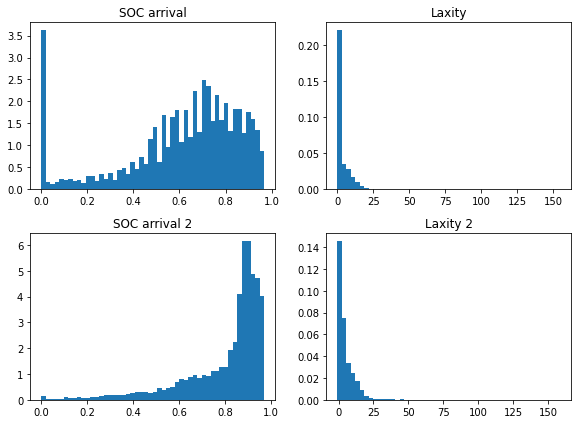

In [23]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)
ax4 = fig1.add_subplot(2,2,4)
df_elaad["laxity2"] = df_elaad["connected_time"] - (config.FINAL_SOC - df_elaad["soc_arr2"]) * config.B / (config.alpha_c*config.eta_c)
_ = ax1.hist(df_elaad["soc_arr"], bins = 50, density = True)
ax1.set_title("SOC arrival")
_ = ax2.hist(df_elaad["laxity"], bins = 50, density = True)
ax2.set_title("Laxity")
_ = ax3.hist(df_elaad["soc_arr2"], bins = 50, density = True)
ax3.set_title("SOC arrival 2")
_ = ax4.hist(df_elaad["laxity2"], bins = 50, density = True)
ax4.set_title("Laxity 2")
fig1.tight_layout()

In [24]:
df_elaad["soc_arr"].describe()

count    9997.000000
mean        0.612447
std         0.257299
min         0.000000
25%         0.498375
50%         0.668160
75%         0.801562
max         0.967305
Name: soc_arr, dtype: float64

In [25]:
df_elaad["laxity2"].describe()  

count    9997.000000
mean        5.062209
std         6.683161
min        -0.803340
25%         1.186549
50%         2.612245
75%         7.088961
max       158.660482
Name: laxity2, dtype: float64

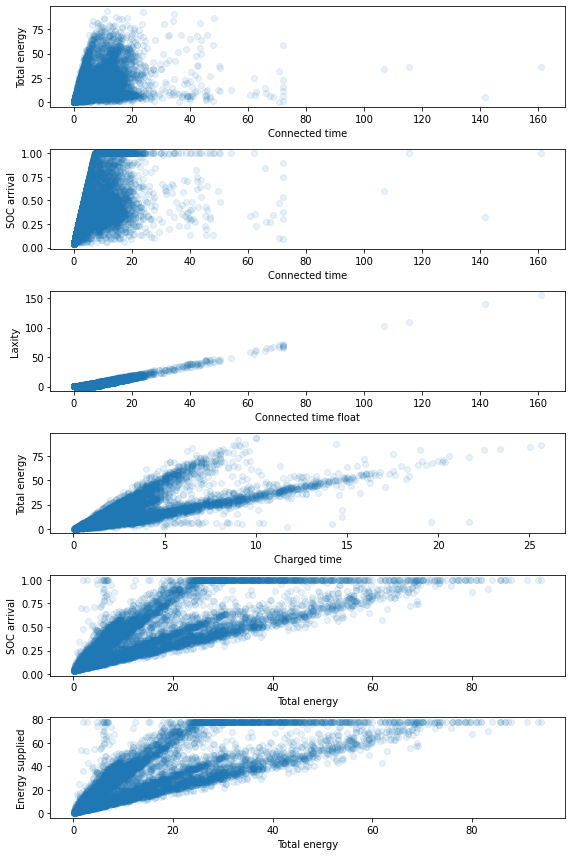

In [29]:
fig1 = plt.figure(figsize = (8,12))
ax1 = fig1.add_subplot(6,1,1)
ax2 = fig1.add_subplot(6,1,2)
ax3 = fig1.add_subplot(6,1,3)
ax4 = fig1.add_subplot(6,1,4)
ax5 = fig1.add_subplot(6,1,5)
ax6 = fig1.add_subplot(6,1,6)

ax1.scatter(df_elaad["connected_time_float"], df_elaad["total_energy"], alpha=0.1)
ax1.set_xlabel("Connected time")
ax1.set_ylabel("Total energy")
ax2.scatter(df_elaad["connected_time_float"], 1-df_elaad["soc_arr"], alpha=0.1)
ax2.set_xlabel("Connected time")
ax2.set_ylabel("SOC arrival")
ax3.scatter(df_elaad["connected_time_float"], df_elaad["laxity"], alpha=0.1)
ax3.set_xlabel("Connected time float")
ax3.set_ylabel("Laxity")
ax4.scatter(df_elaad["charged_time_float"], df_elaad["total_energy"], alpha=0.1)
ax4.set_xlabel("Charged time") 
ax4.set_ylabel("Total energy")
ax5.scatter(df_elaad["total_energy"], 1-df_elaad["soc_arr"], alpha=0.1)
ax5.set_xlabel("Total energy")
ax5.set_ylabel("SOC arrival")
ax6.scatter(df_elaad["total_energy"], df_elaad["energy_supplied"], alpha=0.1)
ax6.set_xlabel("Total energy")
ax6.set_ylabel("Energy supplied")
fig1.tight_layout()

In [28]:
df_elaad["laxity"].describe()

count    9.997000e+03
mean     3.672141e+00
std      6.333161e+00
min     -4.440892e-16
25%      5.300000e-01
50%      9.600000e-01
75%      4.801484e+00
max      1.548015e+02
Name: laxity, dtype: float64